# 3 Pre-Processing and Training Data<a id='3_Pre-Processing_and_Training_Data'></a>

  * [3.1 Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Imports](#3.3_Imports)
  * [3.4 Load the Data](#3.4_Load_Data)
  * [3.5 Scale the Dataset](#3.5_Scale_Dataset)
  * [3.6 Train/Test Split](#3.6_Train_Test_Split)
  * [3.7 Use Pycaret to Examine Best Model](#3.7_Use_Pycaret)
  * [3.8 Summary](#3.8_Summary)

## 3.2 Introduction<a id='3.2_Introduction'></a>

In preceding notebooks, the preliminary assessments of data quality and exploratory data analysis were conducted. Some features were removed, some missing values were discarded, some features were scaled, and the target was determined to be the insurance premium, which was scaled to log10. 

In this notebook, we will use pycaret to find several best machine learning models to fit the dataset. In the next notebook, we will select a few models to practice and to analyze the model performance.

## 3.3 Imports<a id='3.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

sns.set_style('darkgrid')
%matplotlib inline

## 3.4 Load the Data<a id='3.4_Load_Data'></a>

In [2]:
df = pd.read_csv('../data/data_for_model.csv')
df.head()

,construction,crsdiscount,deductibleamountinbuildingcoverage,deductibleamountincontentscoverage,elevatedbuildingindicator,elevationdifference,numberoffloorsininsuredbuilding,primaryresidenceindicator,smallbusinessindicatorbuilding,buildingage,...,locationofcontents_E,occupancytype_2,occupancytype_3,occupancytype_4,occupancytype_6,ratemethod_2,ratemethod_B,ratemethod_W,premium_scale,coverage_scale
0,0,3.0,6.0,4.0,0,1,1.0,1,0,38.0,...,0,0,0,0,0,0,0,0,2.860937,5.406199
1,0,5.0,2.0,2.0,0,7,1.0,1,0,45.0,...,0,0,0,0,0,0,1,0,2.324282,5.079181
2,0,5.0,2.5,2.5,0,0,1.0,0,0,20.0,...,0,0,0,0,0,0,0,0,3.187521,5.544068
3,0,5.0,2.5,2.5,0,3,2.0,1,0,43.0,...,0,1,0,0,0,0,1,0,2.550228,5.482874
4,0,5.0,2.5,2.5,0,3,1.0,1,0,61.0,...,0,0,0,0,0,0,1,0,2.423246,5.195900


Let's take a look of the distribution of the target. 

<AxesSubplot:xlabel='premium_scale', ylabel='Count'>

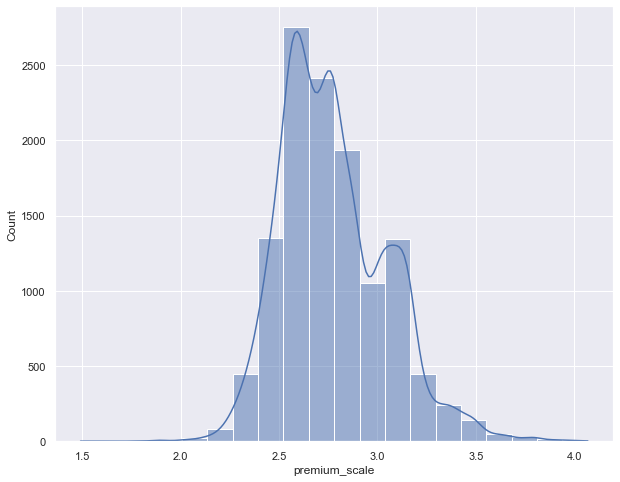

In [3]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.histplot(data=df, x='premium_scale', bins=20, kde=True)

## 3.5 Scale the Dataset<a id='3.5_Scale_Dataset'></a>

In [4]:
#Because the numerical features have different ranges, so let's scale the numeric features
#For categorical features, we keep values of 0 and 1 for those created by pd.dummies
scaler = StandardScaler()

df['crsdiscount'] = scaler.fit_transform(df[['crsdiscount']])
df['deductibleamountinbuildingcoverage'] = scaler.fit_transform(df[['deductibleamountinbuildingcoverage']])
df['deductibleamountincontentscoverage'] = scaler.fit_transform(df[['deductibleamountincontentscoverage']])
df['elevationdifference'] = scaler.fit_transform(df[['elevationdifference']])
df['numberoffloorsininsuredbuilding'] = scaler.fit_transform(df[['numberoffloorsininsuredbuilding']])
df['buildingage'] = scaler.fit_transform(df[['buildingage']])
df['coverage_scale'] = scaler.fit_transform(df[['coverage_scale']])

df.head()

,construction,crsdiscount,deductibleamountinbuildingcoverage,deductibleamountincontentscoverage,elevatedbuildingindicator,elevationdifference,numberoffloorsininsuredbuilding,primaryresidenceindicator,smallbusinessindicatorbuilding,buildingage,...,locationofcontents_E,occupancytype_2,occupancytype_3,occupancytype_4,occupancytype_6,ratemethod_2,ratemethod_B,ratemethod_W,premium_scale,coverage_scale
0,0,-0.629748,0.385591,-0.103125,0,-0.195422,-0.797508,1,0,0.036876,...,0,0,0,0,0,0,0,0,2.860937,0.115154
1,0,0.628932,-0.678399,-0.644921,0,2.886355,-0.797508,1,0,0.404039,...,0,0,0,0,0,0,1,0,2.324282,-1.626907
2,0,0.628932,-0.545400,-0.509472,0,-0.709052,-0.797508,0,0,-0.907258,...,0,0,0,0,0,0,0,0,3.187521,0.849595
3,0,0.628932,-0.545400,-0.509472,0,0.831837,0.642022,1,0,0.299136,...,0,1,0,0,0,0,1,0,2.550228,0.523605
4,0,0.628932,-0.545400,-0.509472,0,0.831837,-0.797508,1,0,1.243269,...,0,0,0,0,0,0,1,0,2.423246,-1.005136


## 3.6 Train/Test Split<a id='3.6_Train_Test_Split'></a>

Now, let's split the dataset into the train and test datasets, with test size of 0.3. We will use the train dataset to find the best model, and then use the model to evaluate the performace of the test dataset.

In [5]:
train, test = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)
print(train.shape)
print(test.shape)

(8632, 30)
(3700, 30)


## 3.7 Use Pycaret to Examine Best Model<a id='3.7_Use_Pycaret'></a>

Here we use pycaret to examine the dataset and to generate several best models.

In [6]:
from pycaret.regression import *
s = setup(data=train, target='premium_scale', fold_shuffle=True, session_id=123)

,Description,Value
0,session_id,123
1,Target,premium_scale
2,Original Data,"(8632, 30)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,22
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(6042, 29)"


We get the performance for all models:

In [7]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0211,0.0020,0.0445,0.9719,0.0116,0.0076,1.0500
xgboost,Extreme Gradient Boosting,0.0241,0.0026,0.0504,0.9642,0.0132,0.0087,0.2190
et,Extra Trees Regressor,0.0252,0.0031,0.0556,0.9565,0.0145,0.0091,0.3980
lightgbm,Light Gradient Boosting Machine,0.0263,0.0033,0.0568,0.9547,0.0147,0.0094,0.1800
rf,Random Forest Regressor,0.0271,0.0036,0.0594,0.9502,0.0154,0.0097,0.3940
gbr,Gradient Boosting Regressor,0.0336,0.0039,0.0618,0.9466,0.0159,0.0119,0.1340
dt,Decision Tree Regressor,0.0325,0.0053,0.0725,0.9260,0.0191,0.0117,0.0580
knn,K Neighbors Regressor,0.0569,0.0111,0.1049,0.8478,0.0271,0.0203,0.0900
ada,AdaBoost Regressor,0.0993,0.0175,0.1320,0.7591,0.0348,0.0360,0.1200
br,Bayesian Ridge,0.1105,0.0218,0.1476,0.6995,0.0401,0.0398,0.0900


Catboost model is the best model based on its highest R2 value. XG Boost, Extra Trees Regression (et), Light Gradient Boosting (lightgbm), and Random Forest Regression (rf) also have very high R2 values. 

In this notebook, we will examine the performance for Catboost model using pycaret package. In the next notebook, we will use sklearn to conduct machine learning practices using a few of these best models: catboost, xgboost, et, rf, and lightgbm. 

In [8]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0196,0.0012,0.0350,0.9852,0.0091,0.0071
1,0.0228,0.0021,0.0458,0.9702,0.0116,0.0080
2,0.0216,0.0027,0.0515,0.9593,0.0127,0.0076
3,0.0212,0.0018,0.0429,0.9735,0.0113,0.0077
4,0.0209,0.0033,0.0574,0.9537,0.0175,0.0082
5,0.0220,0.0021,0.0456,0.9735,0.0115,0.0078
6,0.0197,0.0016,0.0396,0.9782,0.0102,0.0071
7,0.0215,0.0018,0.0428,0.9741,0.0110,0.0076
8,0.0216,0.0022,0.0470,0.9698,0.0120,0.0078
9,0.0198,0.0014,0.0370,0.9817,0.0094,0.0071


Let's tune the model by using 'RMSE' as the goal. 

In [9]:
tuned_catboost = tune_model(catboost, optimize = 'R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0397,0.0046,0.0677,0.9447,0.0170,0.0140
1,0.0403,0.0047,0.0689,0.9324,0.0177,0.0143
2,0.0368,0.0052,0.0720,0.9206,0.0181,0.0130
3,0.0362,0.0041,0.0642,0.9407,0.0167,0.0131
4,0.0410,0.0072,0.0846,0.8994,0.0238,0.0153
5,0.0390,0.0058,0.0760,0.9263,0.0189,0.0136
6,0.0358,0.0039,0.0624,0.9460,0.0160,0.0128
7,0.0377,0.0044,0.0662,0.9381,0.0167,0.0132
8,0.0401,0.0056,0.0748,0.9234,0.0191,0.0144
9,0.0384,0.0041,0.0638,0.9456,0.0163,0.0137


It turns out that the tuned model actually performs worse with lower R2. Therefore, the original model is selected.

In [10]:
evaluate_model(catboost)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

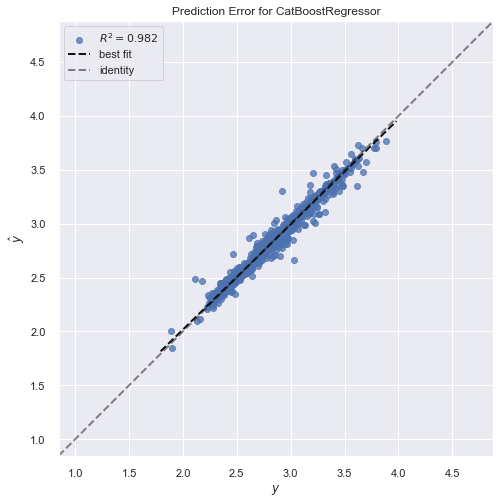

In [11]:
sns.set(rc = {'figure.figsize':(10,8)})
plot_model(catboost, plot = 'error')

The above plot shows the actual value vs. estimated value for the target. Most of the data points fall onto the 1:1 line.

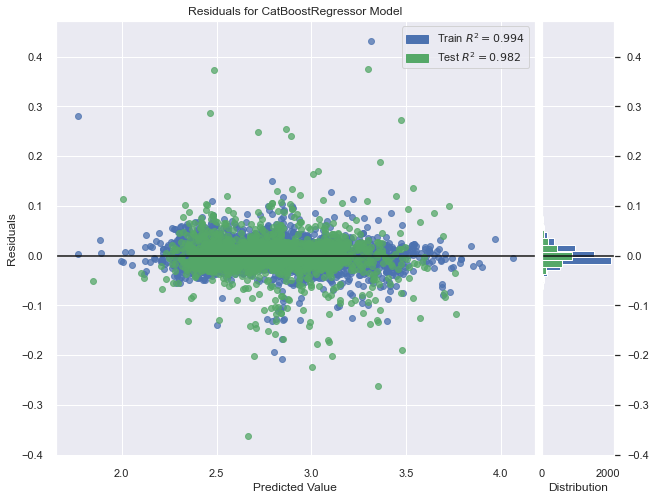

In [12]:
sns.set(rc = {'figure.figsize':(10,8)})
plot_model(catboost, plot = 'residuals')

The above plot shows the residuals vs. estimated value for the target. Most of the residuals are close to 0, and the majority residual is below 0.2, i.e., the error insurance premium is 10^(0.2) = 2, which suggests that the estimated insurance premium price is about actual premium price + (or -) 2 dollors. 

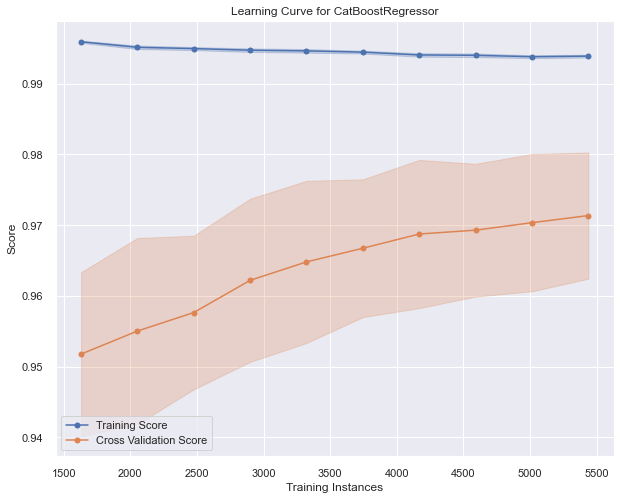

In [13]:
sns.set(rc = {'figure.figsize':(10,8)})
plot_model(catboost, plot = 'learning')

From the learning curve plot above, we can see that the learning curves show low bias (i.e. high accuracy rates) and low variance, which shows the two curves are converging.

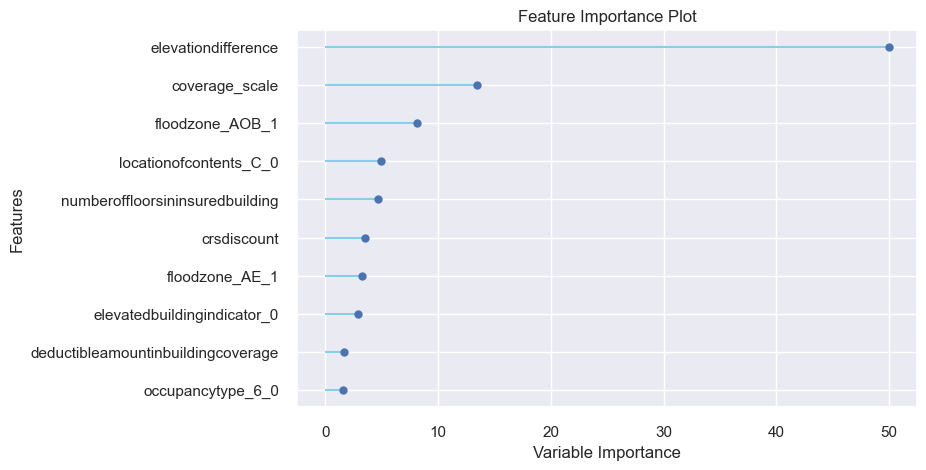

In [14]:
sns.set(rc = {'figure.figsize':(10,8)})
plot_model(catboost, plot = 'feature')

From the feature importance chart above, we can see that elevation difference is the most important parameter, followed by total coverage. which is expected based on the EDA. Furthermore, flood zone of AOB, location of contents, number of floors, crs discount, elevated building indicator, deductible of building coverage, and occupancy type seem to play an important role as well.

In [15]:
cb = finalize_model(catboost)

In [16]:
predictions_test = predict_model(cb, data=test)
predictions_test.head(10)

,construction,crsdiscount,deductibleamountinbuildingcoverage,deductibleamountincontentscoverage,elevatedbuildingindicator,elevationdifference,numberoffloorsininsuredbuilding,primaryresidenceindicator,smallbusinessindicatorbuilding,buildingage,...,occupancytype_2,occupancytype_3,occupancytype_4,occupancytype_6,ratemethod_2,ratemethod_B,ratemethod_W,premium_scale,coverage_scale,Label
8917,0,-0.629748,-0.545400,-0.509472,0,0.318207,-0.797508,0,0,-1.169517,...,0,0,0,1,0,0,0,2.788875,1.799081,2.810016
772,0,0.628932,-0.146404,-0.103125,1,-0.709052,0.642022,1,0,-1.274421,...,0,0,0,0,0,0,0,2.622214,0.161893,2.651777
12252,0,-0.629748,-0.545400,-0.509472,0,-0.195422,0.642022,1,0,0.036876,...,0,0,0,0,0,0,0,2.740363,-0.081862,2.754842
7793,0,0.628932,1.449580,1.522265,0,-0.709052,0.642022,1,0,0.928558,...,0,0,0,0,0,1,0,2.907411,0.849595,2.907135
6601,0,0.628932,-0.545400,-0.509472,1,-0.195422,0.642022,1,0,-1.589132,...,0,0,0,0,0,0,0,2.791691,0.849595,2.764152
247,0,0.628932,-0.545400,-0.509472,0,0.318207,0.642022,1,0,-0.907258,...,0,0,0,0,0,0,0,2.640481,0.849595,2.630219
4610,0,0.628932,-0.146404,-0.103125,0,-0.709052,0.642022,0,0,0.299136,...,0,1,0,0,0,1,0,3.315551,1.713319,3.344357
218,0,-0.629748,-0.545400,-0.509472,0,0.831837,0.642022,1,0,-0.068028,...,0,0,0,0,0,0,0,2.495544,0.161893,2.529160
4023,0,0.628932,-0.545400,-0.509472,0,0.318207,-0.797508,1,0,-1.903843,...,0,0,0,0,0,0,0,2.687529,0.849595,2.704688
4246,0,0.628932,-0.545400,-0.915820,0,1.345466,-0.797508,1,0,-0.907258,...,0,0,0,0,0,0,0,2.340444,-0.507231,2.353213


Column 'premium_scale' shows the actual premium_scale value whereas column 'Label' shows the estimated premium_scale value for the test dataset. We can see that the predicted values are very close to the actual values. 

In [17]:
predictions_train = predict_model(cb, data=train)
predictions_train.head(10)

,construction,crsdiscount,deductibleamountinbuildingcoverage,deductibleamountincontentscoverage,elevatedbuildingindicator,elevationdifference,numberoffloorsininsuredbuilding,primaryresidenceindicator,smallbusinessindicatorbuilding,buildingage,...,occupancytype_2,occupancytype_3,occupancytype_4,occupancytype_6,ratemethod_2,ratemethod_B,ratemethod_W,premium_scale,coverage_scale,Label
1568,0,-0.629748,-0.545400,-0.509472,0,-0.195422,-0.797508,1,0,0.036876,...,0,0,0,0,0,0,0,2.881955,-0.086810,2.875410
462,0,-0.629748,-0.545400,-0.509472,0,-0.709052,0.642022,1,0,0.246684,...,0,0,0,0,0,0,0,3.077004,0.849595,3.071342
743,0,0.628932,-0.545400,-0.509472,0,-0.195422,-0.797508,1,0,-0.068028,...,0,0,0,0,0,0,0,2.835056,0.049772,2.828591
222,0,0.628932,-0.545400,-0.509472,1,0.831837,2.081551,1,0,-1.064613,...,0,0,0,0,0,0,0,2.568202,0.849595,2.561002
7954,0,-0.629748,-0.545400,-0.509472,0,0.831837,0.642022,1,0,-1.746488,...,0,0,0,0,0,0,0,2.606381,0.492962,2.589484
11350,0,-2.517769,-0.146404,-0.103125,0,0.831837,2.081551,1,0,-1.694036,...,0,0,0,0,0,0,0,2.684845,0.849595,2.686173
3912,0,0.628932,-0.545400,-0.509472,0,-0.709052,-0.797508,1,0,-0.068028,...,0,0,0,0,0,0,0,3.165541,0.327554,3.148498
625,0,-0.629748,0.385591,0.438672,0,-0.195422,0.642022,0,0,0.141780,...,0,0,0,0,0,0,0,2.673942,-0.503669,2.669744
10659,0,-0.629748,1.449580,1.522265,0,-0.709052,0.642022,1,0,0.928558,...,0,0,0,0,0,1,0,2.961421,0.849595,2.956716
11700,0,-0.629748,-0.545400,-0.509472,0,-0.195422,-0.797508,1,0,0.351588,...,0,0,0,0,0,0,0,2.510545,-0.261694,2.506857


Similarly, column 'premium_scale' shows the actual premium_scale value whereas column 'Label' shows the estimated premium_scale value for the train dataset. We can see that the predicted values are very close to the actual values.

## 3.8 Summary<a id='3.8_Summary'></a>

In this notebook, we split the original dataset into train and test datasets, and use pycaret to find several good models for the dataset in a quick way. It turns out that Catboost regression, XG Boosting, Extra Trees Regression, Random Forest regression, and Light Gradient Boosting are all good machine learning models for this dataset. 

In the next notebook, we will use scikit-learn package to conduct machine learning practices on a few of these models to check their performances.